# DGA Detection using machine learning

### Identification of domain names generated from Domain Generating Algorithms (DGAs)

* **Author:** Suyash Sathe
* **Date:** 11 December 2019
* **Email:** suyash0106@outlook.com


## Introduction

DGA (**Domain Generating Algorithms**) is a technique used in computer malware programs to generate large number of domain names. These domain names are generated periodically out of which one is the address of the control server and is used to communicate with the command and control server. 

The objective of this analysis is to select the best machine learning model to predict the domain names that are generated from DGAs. In this analysis, a dataset containing approximately **130,000** domains names was explored and analysed to obtain the best set of features that are crucial for predicting the domain names generated from DGAs. These features are converted into vectorized format for the purpose of building machine learning models.

This vectorized representation of features was then utilised to train 3 different classification models including Logistic Regression, Random Forest and SVM, and the performance of these models was evaluated based the accuracy score and the recall value. After comparing the models, the best model was utilised to predict the domain names that are generated from DGAs.

### Programming Language
* Python 3.7 in Jupyter Notebook

### Python Libraries Used
* Pandas           
* Sklearn          
* Numpy       
* Matplotlib    
* pickle           
* Seaborn

### Note
The packages used in this code file must be installed explicitly using "pip" if they are not already installed.

**Syntax:** pip install *package name*

# Import Libraries

Load the following set of libraries and packages

In [50]:
# EDA Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Packages
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score

# SVM as the classifier
from sklearn import svm

# Random Forest as the classifier
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression as the classifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Read the data

Load the *dga_domains.csv* data from the following url and store it in the *urls_data* variable

In [13]:
# Load Url Data 
urls_data = pd.read_csv("https://datasci-test.s3-ap-southeast-2.amazonaws.com/dga_domains.csv")

# Check the first few elements of the dataset
urls_data.head()

,host,domain,class,subclass
0,000directory.com.ar,000directory,legit,legit
1,000webhost.com,000webhost,legit,legit
2,001fans.com,001fans,legit,legit
3,01-telecharger.com,01-telecharger,legit,legit
4,010shangpu.com,010shangpu,legit,legit


Separate the data into predictors and the target variable.

In [19]:
# Labels
y = urls_data["class"]

# Predictors
url_list = urls_data["host"]

## Data Exploration

Check the dimensionality of the dataset. This dataset has 133926 rows and 4 columns.

In [114]:
# Check the dimensions of the dataset
urls_data.shape

(133926, 5)

Get the statistical details of the urls data.

In [12]:
# Get a summary of statistics of the data
urls_data.describe()

,host,domain,class,subclass
count,133926,133926,133926,133926
unique,133926,114525,2,4
top,drhorton.com,provincia,legit,legit
freq,1,47,81261,81261


Get the unique values of the "class" column.

In [115]:
urls_data["class"].unique()

array(['legit', 'dga'], dtype=object)

Get the unique values of the "subclass" column.

In [92]:
urls_data["subclass"].unique()

array(['legit', 'newgoz', 'cryptolocker', 'goz'], dtype=object)

Checking for null values in the dataset, there are 0 null values in this dataset.

In [11]:
# Check for null values
urls_data.isnull().sum()

host        0
domain      0
class       0
subclass    0
dtype: int64

Check how the host name compares across legitimate and DGA generated domain names.

In [7]:
print ("<<<<<<<< DGA >>>>>>>>>")
print (urls_data.host[urls_data["class"] == "dga"].describe())
print ()
print ("<<<<<<<< LEGIT >>>>>>>>>")
print (urls_data.host[urls_data["class"] == "legit"].describe())

<<<<<<<< DGA >>>>>>>>>
count                              52665
unique                             52665
top       a67hdl5r700e18b9vgj1ntfuar.biz
freq                                   1
Name: host, dtype: object

<<<<<<<< LEGIT >>>>>>>>>
count                81261
unique               81261
top       motorsport.co.za
freq                     1
Name: host, dtype: object


#### Distribution of length of the domain names

It can be clearly observed from the distribution of URL lengths that the distribution of length of legitimate URLs is right skewed. That is legitimate URLs are of short length typically 10-20 characters. As the length of the URL increases beyond 20 characters, the probability of it being generated by a DGA becomes more.

The above hypothesis is supported by the distribution of the length of DGA host names. It can be observed from the below graph that the length of DGA generated domain names is symmetrically distributed around the length of 30 characters. This indicates that if the length of the URL is around 30 characters, then it is highly likely generated using a DGA. However, this is not always true since there are a significant number of URLs whose length is between 15-20 characters.

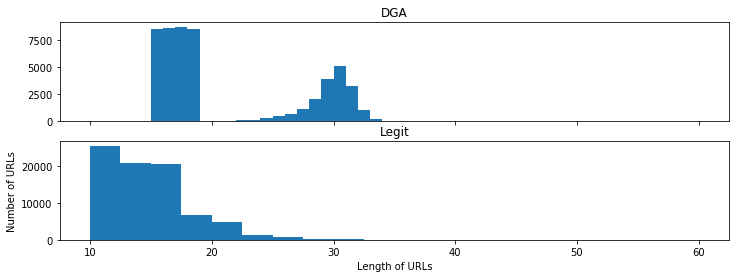

In [14]:
urls_data['URLLength'] = urls_data['host'].apply(len)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 20

ax1.hist(urls_data['URLLength'][urls_data['class'] == "dga"], bins = bins)
ax1.set_title('DGA')

ax2.hist(urls_data['URLLength'][urls_data['class'] == "legit"], bins = bins)
ax2.set_title('Legit')

plt.xlabel('Length of URLs')
plt.ylabel('Number of URLs')
plt.show()

## Data Vectorization

The first step in the data vectorization process is to tokenize the data. Since the *domain* column of the *dga_domains* columns miss the vital information including the domain extension (.com, .net, etc.) which may be necessary to detect the DGA, the following customised function *makeTokens* is defined to tokenize the URL into the components split by "/", "-" and "." if present in the URL. This tokenizer is used in the *CountVectorizer* object to represent the features into vectorized format. It also removes unnecessary tokens like ".com" which may become redundant features if used to train model.

In [22]:
# Function to tokenize the URL
def makeTokens(f):
    
    # make tokens after splitting by slash
    tkns_BySlash = f.split('/')
    
    # Create a list to store the tokenized data
    total_Tokens = []
    
    for i in tkns_BySlash:
        
        # make tokens after splitting by dash
        tokens = str(i).split('-')
        
        # Create a list to store the tokens split by dot
        tkns_ByDot = []
        
        for j in range(0,len(tokens)):
            
            # make tokens after splitting by dot
            temp_Tokens = str(tokens[j]).split('.')
            
            tkns_ByDot = tkns_ByDot + temp_Tokens
            
        total_Tokens = total_Tokens + tokens + tkns_ByDot
    
    #remove redundant tokens
    total_Tokens = list(set(total_Tokens))
    
    #removing .com since it occurs a lot of times and it should not be included in our features
    if 'com' in total_Tokens:
        total_Tokens.remove('com')
        
    return total_Tokens

Test the tokenization of "100xuexi.net"

In [112]:
test_url = "100xuexi.net"
makeTokens(test_url)

['100xuexi', '100xuexi.net', 'net']

Test the tokenization of "100bestbuy.com" and verify the tokens should not contain "com" as token

In [113]:
test_url = "100bestbuy.com"
makeTokens(test_url)

['100bestbuy', '100bestbuy.com']

Another important step is to convert the word tokens into vectorized form for the machine learning algorithm to use these vectors easily for processing. Here, *CountVectorizer* is used to convert the extracted features into vectorized format. In this project, we are are using a custom tokenizer.

In [25]:
# Using Custom Tokenizer
vectorizer = CountVectorizer(tokenizer=makeTokens)

# Using Default Tokenizer
# vectorizer = CountVectorizer()

For convenience, the familiar term *X* is used to represent the input vector

In [26]:
# Store vectors into X variable as Our XFeatures
X = vectorizer.fit_transform(url_list)

## Training and Testing Data

Sklearn's **train_test_split** function is used to split the data into training set and testing set. The data is split in the ratio of 8:2 where training data is 80% while testing data is 20%.

*X_train* and *y_train* represents the training set while *X_test* and *y_test* represents the testing set.

In [27]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Development

The vectorized representation of the data is  utilised for the development of model. In this
section 3 types of models are developed including:

• Logistic Regression Model

• Random Forest Model

• SVM Model

### Logistic Regression Model

An instance of the logistic regression model is created and fed with the sparse vector word representation of the labeled training dataset in the form of *CountVector* sparse matrix. This model is used to predict the labels of test dataset *X_test* and the results are recorded. Finally the accuracy of the model is recorded using the *score* function of the *sklearn* library. It is recorded that this model gives an accuracy of 0.916 indicating 92% of the times the model predicts the target variable correctly.

In [32]:
# Model Building using logistic Regression
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred_logit = logit.predict(X_test)

In [29]:
# Accuracy of logit model
print("Accuracy of Logistic Regression Model is ",logit.score(X_test, y_test))

Accuracy of Logistic Regression Model is  0.9156648995744046


#### Cross validation on Logistic Regression Model
To generalize the model about the sample data point estimation, 10-fold cross validation is performed in the below step. This improves the generalization of the model, prevents overfitting and usually improves the accuracy when the model is deployed in the production environment.

The average accuracy recorded using 10-fold cross validation is 0.905. This is very close to the accuracy obtained using the traditional 80-20 split indicating that the dataset is evenly distributed. Since the data is evenly distributed and cross-validation is computationally expensive, it is feasible to use 80-20  train-test split.

In [30]:
lr_cv = cross_val_score(LogisticRegression(), X, y, cv=10)
mean_lr_cv = np.mean(lr_cv)

print("Average accuracy of Logistic Regression Model is ", mean_lr_cv)

Average accuracy of Logistic Regression Model is  0.9048983739640828


#### Recall value of Logistic Regression Model

An important consideration in building an appropriate ML model for predicting the DGA generated domain names is minimising the number of *False Negatives*. In this scenario, *False Negatives* are the number of domain names that are incorrectly predicted as legitimate (non-DGA domain name) by the model.

*Recall* tells us what proportion of domain names that were actually generated from DGA were detected correctly by the algorithm. Therefore, the *recall* of a  desirable model will be as close to 100% as possible.

In [64]:
print("Recall value of Logistic Regression Model is ", recall_score(y_test, y_pred_logit, average="macro"))

Recall value of Logistic Regression Model is  0.9093286813393757


#### Save the model

Save the trained model in a separate file on the disk.

In [116]:
# Uncomment the below code to save the trained model in a separate file on the disk.

# filename = 'logit_model.sav'
# pickle.dump(logit, open(filename, 'wb'))

## Random Forest Model

Random Forest is another machine learning algorithm for performing classification tasks. In this step, a Random Forest model with default parameters is implemented on the training set. The default number of trees in this case is 10. The accuracy obtained using this model is very close, however, slightly less that the logistic regression model.

In [36]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [37]:
print("Accuracy of Random Forest Model is ",rf.score(X_test, y_test))

Accuracy of Random Forest Model is  0.9107369521391772


#### Cross validation on Random Forest Model

This step is computationally expensive and is performed just for the purpose of experimentation. The average accuracy of *random forest classifier* (.903) is also very close to that of the average accuracy of the logistic regression model.

**Note:** This block of code takes approximately 3 hours to run on a Windows machine.

In [38]:
rf_cv = cross_val_score(RandomForestClassifier(), X, y, cv=10)
mean_rf_cv = np.mean(rf_cv)

print("Average accuracy of Random Forest Model is ", mean_rf_cv)

Average accuracy of Random Forest Model is  0.9028375859106459


#### Recall value of Random Forest Model

In [39]:
print("Recall value of Random Forest Model is ", recall_score(y_test, y_pred_rf, average="macro"))

Recall value of Random Forest Model is  0.8961672727660649


#### Save the model

Save the trained model in a separate file on the disk.

In [117]:
# Uncomment the below code to save the trained model in a separate file on the disk.

# filename = 'rf_model.sav'
# pickle.dump(rf, open(filename, 'wb'))

## SVM Model

Support Vector Machine (SVM) is a linear model for classification which creates a hyperplane in an n-dimensional space to separate the data for each class. This model is trained on the training dataset to create the linear hyperplane boundaries for each class in the entire corpus of the data set. The kernel type used in this model is *linear* assuming the data is linearly separable. 

It is observed that this model yields the best accuracy and recall score. It is as memory efficient as logistic regression, and less sensitive to outliers than the logistic regression model. However, SVM solves the *quadratic programming problem* (QP) to find a separation hyperplane and this is computationally very intensive. Eventhough this model yields the best results, this model is not the most suitable when the dataset has large number of samples.

Please note that this step is computationally expensive and takes approximately 1 hour to train the model on a Windows machine.

In [41]:
# Perform classification with SVM with a linear kernel
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [74]:
# get the accuracy
print("Accuracy of SVM Model is ", svm_model.score(X_test, y_test))

Accuracy of SVM Model is  0.9191368625401329


#### Recall value of SVM Model

In [63]:
print("Recall value of SVM Model is ", recall_score(y_test, y_pred_svm, average="macro"))

Recall value of SVM Model is  0.9122006472463611


#### Save the model

Save the trained model in a separate file on the disk.

In [91]:
# Uncomment the below code to save the trained model in a separate file on the disk.

# filename = 'svm_model.sav'
# pickle.dump(svm_model, open(filename, 'wb'))

# Multiclass Logistic Regression Model

From the above results, it is learned that the traditional machine learning methods all perform in almost the same range. Since logistic regression offers an easy to implement and highly generalizable approach, this approach is also used to solve the multi-class classification problem of predicting the DGA subclasses.

Store the subclass target variable separately

In [75]:
# Sub class labels
y_subclass = urls_data["subclass"]

Using the new target variable, create new train-test split. From the above analysis, the data is fairly distributed. Hence, we will stick to the 80-20 split instead of cross validation approach.

In [83]:
# Split the data into training set and testing set
X_train, X_test, y_subclass_train, y_subclass_test = train_test_split(X, y_subclass, test_size=0.2, random_state=42)

A similar instance of logistic instance is created but this time for multiclass classification. Since this is a multiclass classification problem, the *solver* used in this model is **saga**

In [84]:
subclass_logit = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', verbose=2)

In [85]:
# Fit the model on the training data
subclass_logit_model = subclass_logit.fit(X_train, y_subclass_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 12 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s finished


In [89]:
print("Accuracy of the multiclass Logistic Regression Model for predicting the subclass is", subclass_logit_model.score(X_test, y_subclass_test))

Accuracy of the multiclass Logistic Regression Model for predicting the subclass is 0.8616814753975958


#### Save the model

Save the trained model in a separate file on the disk. This model is used to predict the subclass of the domain names.

In [118]:
# Uncomment the below code to save the trained model in a separate file on the disk.
# filename = 'multiclass_logit_model.sav'
# pickle.dump(subclass_logit_model, open(filename, 'wb'))

# Conclusion

From the above results and the overall attempt at identification of the domain names generated from Domain Generating Algorithms (DGAs), it is learned that the traditional machine learning methods all perform in almost the same range. Though SVM is a suitable classifier for such type of problems with high dimensional vector spaces, it is computationally quite expensive over a large sample of dataset and logistic regression offers an easy to implement and highly generalizable approach. Hence, logistic regression model is a more suitable model for this classification problem.